### Import Module

In [1]:
import pandas as pd
import numpy as np

### Prepare columns of interest and specify their types

In [2]:
# Init constant var to store desired cols and their types
DTYPE_DICT = {
    "user_id": pd.Int64Dtype(),
    "status": pd.StringDtype(),
    "timestamp": pd.Int64Dtype(),
    "data.user_data.meta.is_private": pd.BooleanDtype(),
    "data.user_data.meta.is_verified": pd.BooleanDtype(),
    "data.user_data.meta.is_business_account": pd.BooleanDtype(),
    "data.user_data.meta.is_professional_account": pd.BooleanDtype(),
    "data.user_data.meta.has_reel": pd.BooleanDtype(),
    "data.user_data.meta.total_posts_count": pd.Int64Dtype(),
    "data.user_data.meta.followers_count": pd.Int64Dtype(),
    "data.user_data.meta.followings_count": pd.Int64Dtype(),
}

# Iteratively get the metrics for posts
post_column_pattern = "data.user_data.post.{}.{}"
post_metrics = {
    "is_video": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "is_pinned": pd.BooleanDtype(),
}

# Populate DTYPE_DICT with desired metrics for 12 posts
for i in range(1, 13):
    for metric, dtype in post_metrics.items():
        column_name = post_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Iteratively get the metrics for reels
reel_column_pattern = "data.user_data.reel.{}.{}"
reel_metrics = {
    "has_audio": pd.BooleanDtype(),
    "video_view_count": pd.Int64Dtype(),
    "comments_count": pd.Int64Dtype(),
    "comments_disabled": pd.BooleanDtype(),
    "taken_at_timestamp": pd.Int64Dtype(),
    "likes_count": pd.Int64Dtype(),
    "video_duration": pd.Float64Dtype(),
}
        
# Populate DTYPE_DICT with desired metrics for 36 reels
for i in range(1, 37):
    for metric, dtype in reel_metrics.items():
        column_name = reel_column_pattern.format(i, metric)
        DTYPE_DICT[column_name] = dtype

# Get a list of desired columns (for `read_csv()`)
columns_to_read = list(DTYPE_DICT.keys())

### Read Data

In [3]:
data = pd.read_csv('.././data/input/instagram.csv',
                  encoding='utf-8',
                  index_col=False,
                  usecols=columns_to_read,
                  dtype=DTYPE_DICT,)

### Filter Data Based on Account

Filter rows:
1. Failed jobs
2. Account with no reels
3. Private accounts
4. Accounts with total posts < 12
5. Accounts with followers < ? (1 for now)

Filter columns:
1. Post-related columns
2. Account type flags
3. Other irrelevant columns


In [4]:
# Filter out the following rows
data = data.loc[
    (data['status'] == 'successful') &
    (data['data.user_data.meta.has_reel'] == True) &
    (data['data.user_data.meta.is_private'] == False) &
    (data['data.user_data.meta.total_posts_count'] >= 12)
    & (data['data.user_data.meta.followers_count'] > 0)
]

# Filter out columns with names containing "data.user_data.post"
columns_to_drop = [col for col in data.columns if 'data.user_data.post' in col]

# Filter out unary cols
columns_to_drop.extend([
    'status',
    'data.user_data.meta.has_reel',
    'data.user_data.meta.is_private',
])

# Filter out other irrelevant columns
columns_to_drop.extend(
    [
        "data.user_data.meta.is_verified",
        "data.user_data.meta.is_business_account",
        "data.user_data.meta.is_professional_account",
    ]
)

data.drop(columns=columns_to_drop, inplace=True)
data

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,data.user_data.reel.1.has_audio,data.user_data.reel.1.video_view_count,data.user_data.reel.1.comments_count,data.user_data.reel.1.comments_disabled,data.user_data.reel.1.taken_at_timestamp,...,data.user_data.reel.35.taken_at_timestamp,data.user_data.reel.35.likes_count,data.user_data.reel.35.video_duration,data.user_data.reel.36.has_audio,data.user_data.reel.36.video_view_count,data.user_data.reel.36.comments_count,data.user_data.reel.36.comments_disabled,data.user_data.reel.36.taken_at_timestamp,data.user_data.reel.36.likes_count,data.user_data.reel.36.video_duration
0,1293559,1722469534,1422,2488,2112,True,1051,1,False,1722370215,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1256735,1722469583,1614,27160,5358,True,2144,1,False,1721673822,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1334585,1722469667,250,552,278,True,232,0,False,1722373466,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,1104262,1722469699,642,2214,1784,True,1322,0,False,1722407648,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,1206869,1722469734,55,702,1232,True,987,5,False,1720877897,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,1284932,1722570803,135,4996,5258,True,3073,33,False,1710255431,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2744,1331319,1722570821,786,1679,2410,True,109,0,False,1722531756,...,1674162607,37,51.633,True,172,1,False,1673911308,42,61.633
2745,1274132,1722570839,229,1518,2238,True,356,1,False,1717043239,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2747,1333719,1722570885,51,737,765,True,568,4,False,1704155392,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Transform Account-based dataframe into Reel-based dataframe

In [5]:
melted = data.melt(
    id_vars=[
        "user_id",
        "timestamp",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
    ],
    var_name="variable",
    value_name="value",
)
melted[["reel_id", "field"]] = melted["variable"].str.extract(r"reel\.(\d+)\.(.+)")
melted.sort_values(["user_id", "reel_id", "field"])

,user_id,timestamp,data.user_data.meta.total_posts_count,data.user_data.meta.followers_count,data.user_data.meta.followings_count,variable,value,reel_id,field
4439,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_count,0,1,comments_count
6535,1018408,1722473971,742,984,643,data.user_data.reel.1.comments_disabled,False,1,comments_disabled
247,1018408,1722473971,742,984,643,data.user_data.reel.1.has_audio,True,1,has_audio
10727,1018408,1722473971,742,984,643,data.user_data.reel.1.likes_count,6,1,likes_count
8631,1018408,1722473971,742,984,643,data.user_data.reel.1.taken_at_timestamp,1722459602,1,taken_at_timestamp
...,...,...,...,...,...,...,...,...,...
118318,1445323,1722544589,12,522,110,data.user_data.reel.9.has_audio,<NA>,9,has_audio
128798,1445323,1722544589,12,522,110,data.user_data.reel.9.likes_count,<NA>,9,likes_count
126702,1445323,1722544589,12,522,110,data.user_data.reel.9.taken_at_timestamp,<NA>,9,taken_at_timestamp
130894,1445323,1722544589,12,522,110,data.user_data.reel.9.video_duration,<NA>,9,video_duration


In [6]:
# Pivot table
transformed = melted.pivot(
    index=[
        "user_id",
        "reel_id",
        "data.user_data.meta.total_posts_count",
        "data.user_data.meta.followers_count",
        "data.user_data.meta.followings_count",
        "timestamp",
    ],
    columns="field",
    values="value",
).reset_index()

# Reassign reel metrics types
for column, dtype in reel_metrics.items():
    transformed[column] = transformed[column].astype(dtype)
transformed["reel_id"] = transformed["reel_id"].astype(pd.Int64Dtype())

# Rename index and columns
transformed.columns.name = None
transformed = transformed.rename(
    columns={
        "timestamp": "scraped_at",
        "taken_at_timestamp": "created_at",
        "data.user_data.meta.total_posts_count": "total_posts",
        "data.user_data.meta.followers_count": "followers",
        "data.user_data.meta.followings_count": "followings",
    }
)

transformed

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,comments_disabled,has_audio,likes_count,created_at,video_duration,video_view_count
0,1018408,1,742,984,643,1722473971,0,False,True,6,1722459602,42.666,137
1,1018408,10,742,984,643,1722473971,1,False,True,7,1712698604,91.5,218
2,1018408,11,742,984,643,1722473971,0,False,True,10,1711573570,98.0,286
3,1018408,12,742,984,643,1722473971,0,False,True,6,1710539213,49.0,285
4,1018408,13,742,984,643,1722473971,0,False,True,6,1710538467,49.012,318
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75451,1445323,5,12,522,110,1722544589,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
75452,1445323,6,12,522,110,1722544589,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
75453,1445323,7,12,522,110,1722544589,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
75454,1445323,8,12,522,110,1722544589,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


### Summarize cleaned data set

In [7]:
def summarize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    summary = []
    for col in df.columns:
        column_data = df[col]
        col_summary = {
            "Column": col,
            "Data Type": column_data.dtype,
            "NA %": column_data.isna().mean() * 100,
            "Unique Values": column_data.nunique(),
            "Mean": column_data.mean() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Median": column_data.median() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Min": column_data.min() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Max": column_data.max() if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Range": (column_data.max() - column_data.min()) if column_data.dtype in [pd.Int64Dtype(), pd.Float64Dtype()] else None,
            "Top Frequency": column_data.value_counts().iloc[0] if not column_data.isna().all() else None,
        }
        
        # Handle boolean columns
        if column_data.dtype == pd.BooleanDtype():
            true_count = column_data.sum()
            false_count = len(column_data) - column_data.isna().sum() - true_count
            col_summary["True Count"] = true_count
            col_summary["False Count"] = false_count
            col_summary["True %"] = (true_count / (true_count + false_count)) * 100
            col_summary["False %"] = (false_count / (true_count + false_count)) * 100
        summary.append(col_summary)

    return pd.DataFrame(summary)

# Get summary
summarize_dataframe(transformed)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2096,1.217091e+06,1.225812e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.850000e+01,1.850000e+01,1.000000e+00,3.600000e+01,3.500000e+01,2096,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,5.699408e+02,3.685000e+02,1.200000e+01,3.075500e+04,3.074300e+04,324,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1507,3.058590e+03,1.055500e+03,2.000000e+01,5.908050e+05,5.907850e+05,252,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.295563e+03,9.120000e+02,0.000000e+00,7.535000e+03,7.535000e+03,216,NaN,NaN,NaN,NaN
5,scraped_at,Int64,0.000000,2072,1.722529e+09,1.722546e+09,1.722469e+09,1.722572e+09,1.027710e+05,72,NaN,NaN,NaN,NaN
6,comments_count,Int64,33.233938,182,3.377439e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,23412,NaN,NaN,NaN,NaN
7,comments_disabled,boolean,33.233938,2,NaN,NaN,NaN,NaN,NaN,50374,5.0,50374.0,0.009925,99.990075
8,has_audio,boolean,33.235263,2,NaN,NaN,NaN,NaN,NaN,47054,47054.0,3324.0,93.401882,6.598118
9,likes_count,Int64,33.233938,722,6.402598e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3125,NaN,NaN,NaN,NaN


### Filter and Handle NAs

In [ ]:
# Drop rows with N/A created_at timestamp
cleaned = transformed.dropna(subset=["created_at"])

# Drop rows with comment disabled and remove this unary column
cleaned = cleaned[cleaned["comments_disabled"] == False].drop(columns=["comments_disabled"])

# Drop rows with video duration < 1 or is NA
cleaned = cleaned[(cleaned["video_duration"] >= 1) | (cleaned["video_duration"].isna())]

# Impute NAs in has_audio as True?
# cleaned_data["has_audio"] = cleaned_data["has_audio"].fillna(True)

# Impute NAs in video_duration as?

# Impute NAs in video_view_count with the average ratio of video_view_count to like_count?

# Preview
summarize_dataframe(cleaned)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2096,1.217372e+06,1.224850e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.471015e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,2096,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.999238e+02,4.770000e+02,1.200000e+01,3.075500e+04,3.074300e+04,220,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1507,3.697743e+03,1.230000e+03,2.000000e+01,5.908050e+05,5.907850e+05,159,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.453927e+03,1.073000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,Int64,0.000000,2072,1.722529e+09,1.722546e+09,1.722469e+09,1.722572e+09,1.027710e+05,72,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,182,3.377774e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,23407,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.001985,2,NaN,NaN,NaN,NaN,NaN,47051,47051.0,3322.0,93.405197,6.594803
8,likes_count,Int64,0.000000,722,6.403146e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3125,NaN,NaN,NaN,NaN
9,created_at,Int64,0.000000,48848,1.678287e+09,1.697519e+09,1.371802e+09,1.722565e+09,3.507629e+08,4,NaN,NaN,NaN,NaN


### Prepare columns

#### 1. Time elapsed from posted time to scraped time (in seconds)

In [9]:
augmented = cleaned.copy()
augmented["time_elapsed"] = (augmented["scraped_at"] - augmented["created_at"])
summarize_dataframe(augmented[["time_elapsed"]])

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency
0,time_elapsed,Int64,0.0,50341,4.424152e+07,24992102.5,728,350696708,350695980,2


Plot and see the distribution of time elapsed

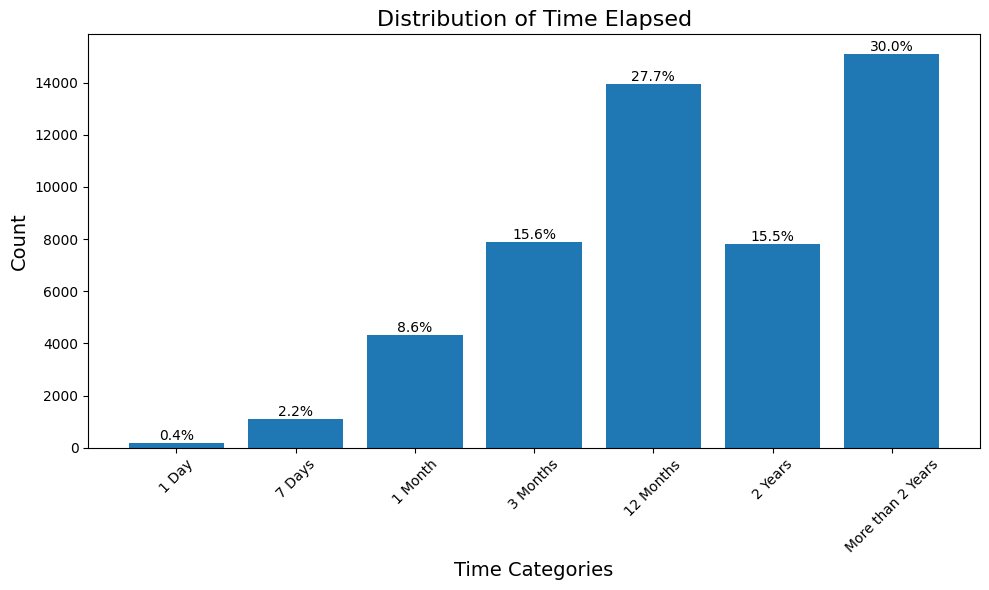

In [10]:
import matplotlib.pyplot as plt

# Define bins in seconds
bins = [
    0, 86400, 604800, 2592000, 7776000, 31104000, 62208000, float('inf')  # From 0 to infinity
]
labels = [
    '1 Day', '7 Days', '1 Month', '3 Months', '12 Months', '2 Years', 'More than 2 Years'
]

# Create a new column for bins
augmented['time_category'] = pd.cut(augmented['time_elapsed'], bins=bins, labels=labels, right=False)

# Calculate distribution and percentages
distribution = augmented['time_category'].value_counts().sort_index()
percentages = (distribution / len(augmented)) * 100

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(distribution.index.astype(str), distribution.values)

# Add percentage labels to each bar
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{percent:.1f}%", ha='center', va='bottom')

# Customize plot
ax.set_title("Distribution of Time Elapsed", fontsize=16)
ax.set_xlabel("Time Categories", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
augmented

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,time_elapsed,time_category
0,1018408,1,742,984,643,1722473971,0,True,6,1722459602,42.666,137,14369,1 Day
1,1018408,10,742,984,643,1722473971,1,True,7,1712698604,91.5,218,9775367,12 Months
2,1018408,11,742,984,643,1722473971,0,True,10,1711573570,98.0,286,10900401,12 Months
3,1018408,12,742,984,643,1722473971,0,True,6,1710539213,49.0,285,11934758,12 Months
4,1018408,13,742,984,643,1722473971,0,True,6,1710538467,49.012,318,11935504,12 Months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75419,1444154,9,692,509,486,1722544013,0,True,1,1705546489,47.999,200,16997524,12 Months
75420,1445323,1,12,522,110,1722544589,0,True,10,1698789189,79.8,167,23755400,12 Months
75431,1445323,2,12,522,110,1722544589,1,True,33,1628640697,22.133,<NA>,93903892,More than 2 Years
75442,1445323,3,12,522,110,1722544589,1,True,22,1622163121,111.433,<NA>,100381468,More than 2 Years


Take out reels that are less than 7 days old

We assume that reels after 7 days are receiving negligible amount of engagement, and those within posted 7 days (from the time the data was collected) are still receiving some. Since these reels consist of less than 3% of the total data, we decide to remove them.

A side note: is it more rational to make the engagement metric relative to the time elaspsed? For example, there's some scalar to be applied to reels posted within 1 day to predict what it would be like in the next week? Maybe not worth the time for just 3% of the data.

In [12]:
augmented = augmented[augmented['time_elapsed'] >= 604800]
# augmented.drop(columns=['time_category'], inplace=True)  # Remove intermediate column
summarize_dataframe(augmented)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2095,1.217438e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.502896e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1921,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.910350e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1506,3.601553e+03,1.228000e+03,2.000000e+01,5.908050e+05,5.907850e+05,154,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.450031e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,Int64,0.000000,2071,1.722529e+09,1.722546e+09,1.722469e+09,1.722572e+09,1.027710e+05,71,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,181,3.409084e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22603,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.002037,2,NaN,NaN,NaN,NaN,NaN,45861,45861.0,3233.0,93.414674,6.585326
8,likes_count,Int64,0.000000,716,6.488736e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3016,NaN,NaN,NaN,NaN
9,created_at,Int64,0.000000,47618,1.677143e+09,1.696021e+09,1.371802e+09,1.721959e+09,3.501571e+08,4,NaN,NaN,NaN,NaN


#### 2. Categorize created_at into weekday

In [13]:
# Convert UTC epoch time to datetime and localize to PST
augmented['created_at'] = pd.to_datetime(augmented['created_at'], unit='s', utc=True)  # Convert from epoch to UTC
augmented['created_at_pst'] = augmented['created_at'].dt.tz_convert('America/Los_Angeles')  # Convert to PST

# Create day_of_week column (Monday=1, ..., Sunday=7)
augmented['day_of_week_pst'] = augmented['created_at_pst'].dt.dayofweek + 1  # Adjust from 0-6 to 1-7

# Define time categories in PST
def categorize_time(hour: int) -> str:
    if 5 <= hour < 12:  # Morning: 5:00 AM to 11:59 AM
        return 'Morning'
    elif 12 <= hour < 17:  # Afternoon: 12:00 PM to 4:59 PM
        return 'Afternoon'
    elif 17 <= hour <= 23:  # Evening: 5:00 PM to 11:59 PM
        return 'Evening'
    else:  # Night: 12:00 AM to 4:59 AM
        return 'Night'

augmented['time_category_pst'] = augmented['created_at_pst'].dt.hour.apply(categorize_time)
augmented

/tmp/ipykernel_12185/431552537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented['created_at'] = pd.to_datetime(augmented['created_at'], unit='s', utc=True)  # Convert from epoch to UTC
/tmp/ipykernel_12185/431552537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented['created_at_pst'] = augmented['created_at'].dt.tz_convert('America/Los_Angeles')  # Convert to PST
/tmp/ipykernel_12185/431552537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,user_id,reel_id,total_posts,followers,followings,scraped_at,comments_count,has_audio,likes_count,created_at,video_duration,video_view_count,time_elapsed,time_category,created_at_pst,day_of_week_pst,time_category_pst
1,1018408,10,742,984,643,1722473971,1,True,7,2024-04-09 21:36:44+00:00,91.5,218,9775367,12 Months,2024-04-09 14:36:44-07:00,2,Afternoon
2,1018408,11,742,984,643,1722473971,0,True,10,2024-03-27 21:06:10+00:00,98.0,286,10900401,12 Months,2024-03-27 14:06:10-07:00,3,Afternoon
3,1018408,12,742,984,643,1722473971,0,True,6,2024-03-15 21:46:53+00:00,49.0,285,11934758,12 Months,2024-03-15 14:46:53-07:00,5,Afternoon
4,1018408,13,742,984,643,1722473971,0,True,6,2024-03-15 21:34:27+00:00,49.012,318,11935504,12 Months,2024-03-15 14:34:27-07:00,5,Afternoon
5,1018408,14,742,984,643,1722473971,0,True,7,2024-03-14 19:57:06+00:00,49.0,411,12027745,12 Months,2024-03-14 12:57:06-07:00,4,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75419,1444154,9,692,509,486,1722544013,0,True,1,2024-01-18 02:54:49+00:00,47.999,200,16997524,12 Months,2024-01-17 18:54:49-08:00,3,Evening
75420,1445323,1,12,522,110,1722544589,0,True,10,2023-10-31 21:53:09+00:00,79.8,167,23755400,12 Months,2023-10-31 14:53:09-07:00,2,Afternoon
75431,1445323,2,12,522,110,1722544589,1,True,33,2021-08-11 00:11:37+00:00,22.133,<NA>,93903892,More than 2 Years,2021-08-10 17:11:37-07:00,2,Evening
75442,1445323,3,12,522,110,1722544589,1,True,22,2021-05-28 00:52:01+00:00,111.433,<NA>,100381468,More than 2 Years,2021-05-27 17:52:01-07:00,4,Evening


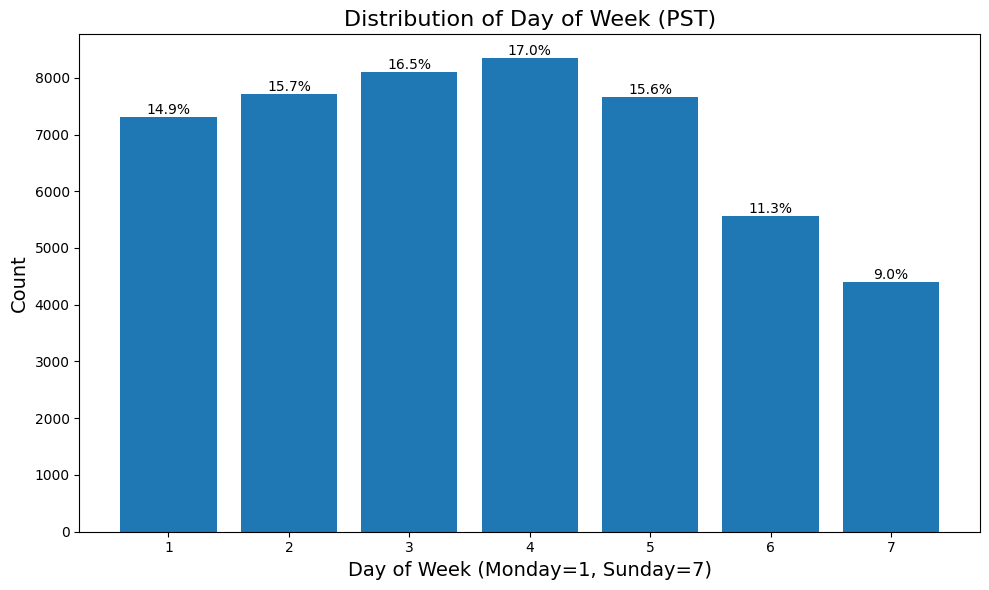

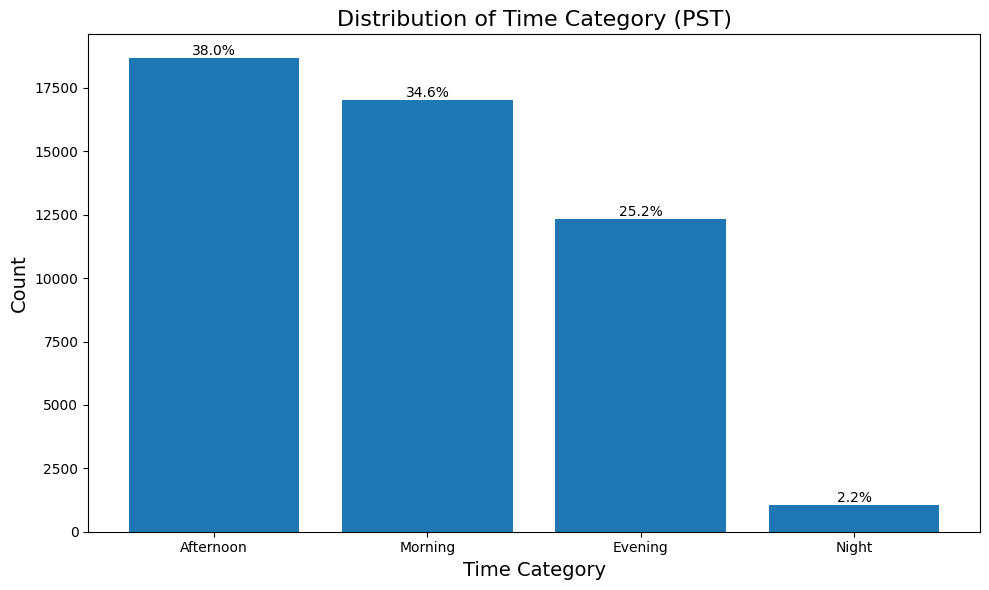

In [14]:
# Plot distribution of `day_of_week_pst`
day_of_week_counts = augmented['day_of_week_pst'].value_counts().sort_index()
day_of_week_percentages = (day_of_week_counts / len(augmented)) * 100

fig, ax1 = plt.subplots(figsize=(10, 6))
bars = ax1.bar(day_of_week_counts.index, day_of_week_counts.values, tick_label=day_of_week_counts.index)

for bar, percent in zip(bars, day_of_week_percentages):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax1.set_title("Distribution of Day of Week (PST)", fontsize=16)
ax1.set_xlabel("Day of Week (Monday=1, Sunday=7)", fontsize=14)
ax1.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

# Plot distribution of `time_category_pst`
time_category_counts = augmented['time_category_pst'].value_counts()
time_category_percentages = (time_category_counts / len(augmented)) * 100

fig, ax2 = plt.subplots(figsize=(10, 6))
bars = ax2.bar(time_category_counts.index, time_category_counts.values, 
               tick_label=time_category_counts.index)

for bar, percent in zip(bars, time_category_percentages):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percent:.1f}%", 
             ha='center', va='bottom')

ax2.set_title("Distribution of Time Category (PST)", fontsize=16)
ax2.set_xlabel("Time Category", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()


In [17]:
summarize_dataframe(augmented)

,Column,Data Type,NA %,Unique Values,Mean,Median,Min,Max,Range,Top Frequency,True Count,False Count,True %,False %
0,user_id,Int64,0.000000,2095,1.217438e+06,1.224878e+06,1.018408e+06,1.445323e+06,4.269150e+05,36,NaN,NaN,NaN,NaN
1,reel_id,Int64,0.000000,36,1.502896e+01,1.400000e+01,1.000000e+00,3.600000e+01,3.500000e+01,1921,NaN,NaN,NaN,NaN
2,total_posts,Int64,0.000000,1022,6.910350e+02,4.740000e+02,1.200000e+01,3.075500e+04,3.074300e+04,217,NaN,NaN,NaN,NaN
3,followers,Int64,0.000000,1506,3.601553e+03,1.228000e+03,2.000000e+01,5.908050e+05,5.907850e+05,154,NaN,NaN,NaN,NaN
4,followings,Int64,0.000000,1430,1.450031e+03,1.075000e+03,0.000000e+00,7.535000e+03,7.535000e+03,143,NaN,NaN,NaN,NaN
5,scraped_at,Int64,0.000000,2071,1.722529e+09,1.722546e+09,1.722469e+09,1.722572e+09,1.027710e+05,71,NaN,NaN,NaN,NaN
6,comments_count,Int64,0.000000,181,3.409084e+00,1.000000e+00,0.000000e+00,2.863000e+03,2.863000e+03,22603,NaN,NaN,NaN,NaN
7,has_audio,boolean,0.002037,2,NaN,NaN,NaN,NaN,NaN,45861,45861.0,3233.0,93.414674,6.585326
8,likes_count,Int64,0.000000,716,6.488736e+01,1.700000e+01,0.000000e+00,3.362760e+05,3.362760e+05,3016,NaN,NaN,NaN,NaN
9,created_at,"datetime64[s, UTC]",0.000000,47618,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN
